Завдання
---
* У цій задачі ми хочемо спрогнозувати кількість пасажирів на рік вперед.
* Для цього потрібно розділити дані на `train` і `test`.
* Натренувати три моделі:
    * Simple Exponential Smoothing (просте згладжування),   
    * Holt’s model (подвійне згладжування),
    * Holt-Winters model (потрійне згладжування).

* Можна зкопіювати функцію для оцінок з лекції або просто порахувати обрану метрику на тестовій вибірці

**Bonus**
Натренувати ETS із оптимальними параметрами та візуалізувати довірчі інтервали

## Імпортування бібліотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import warnings
warnings.simplefilter('ignore')

## Завантаження даних

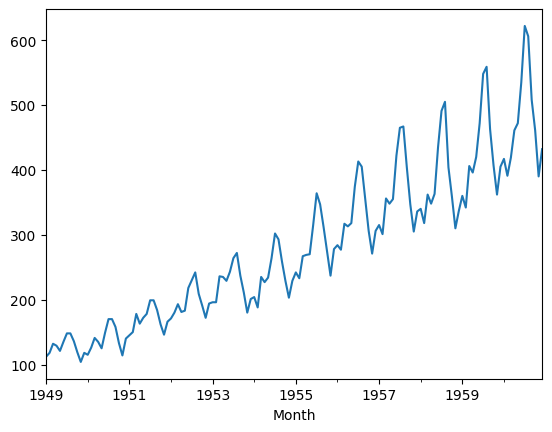

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=[0], index_col=[0])
ts = df['Passengers']
ts.index = pd.DatetimeIndex(ts.index).to_period('M')
ts.plot()
plt.show()

* Ми вже працювали з цим датасетом раніше.
* Дані мають лінійний тренд, тому задаємо `trend='add'`.
* Дисперсія зростає разом із трендом, отже, обираємо мультиплікативну сезонність `seasonal='mul'`.

In [17]:
train, test = df[:-12], df[-12:]

In [18]:
def estimat_plot(train, test, preds):
    r2 = r2_score(test, preds)
    print(f'R2-score = {r2}')
    plt.plot(train.index, train, label='Train', color='green')
    plt.plot(test.index, preds, label='Predicion', color='red')
    plt.plot(test.index, test, label='Actual', color='purple')
    plt.legend()
    plt.show()

R2-score = -0.9142918914417368


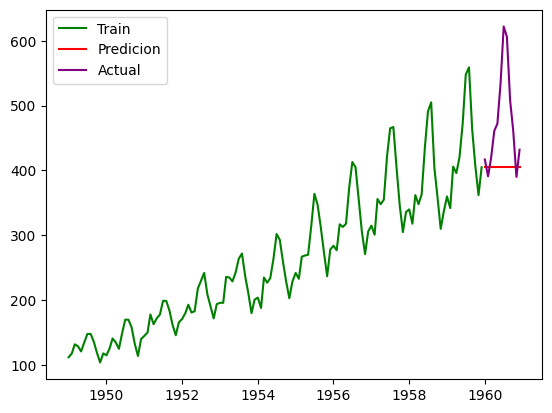

In [21]:
# TODO: Побудувати та оцінити модель Simple Exponential Smoothing
train.index = pd.to_datetime(train.index)
model = SimpleExpSmoothing(train)
model = model.fit(optimized=True)
predictions = model.forecast(len(test))
estimat_plot(train, test, predictions)

R2-score = -0.9142918914417368


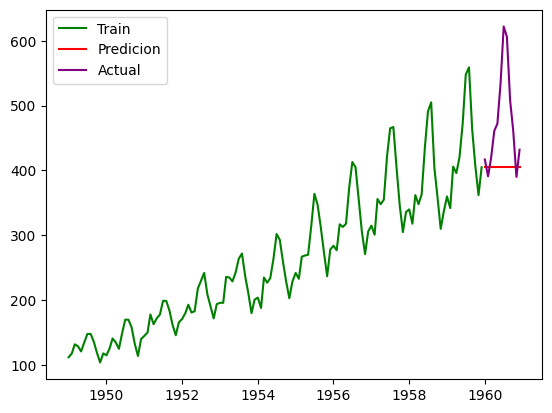

In [22]:
model_holt = Holt(train).fit(optimized=True)
predicitons = model_holt.forecast(len(test))
estimat_plot(train, test, predictions)

R2-score = 0.947945221164409


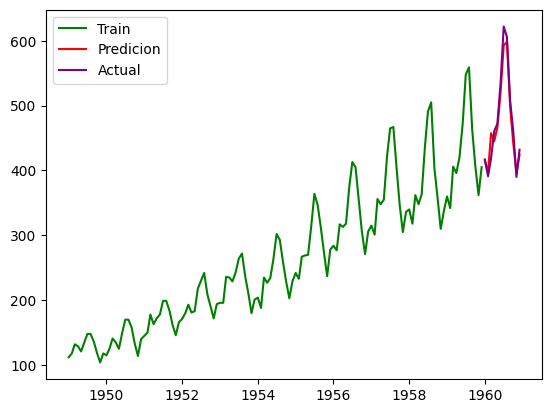

In [23]:
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
model = model.fit(optimized=True)
predictions = model.forecast(len(test))
estimat_plot(train, test, predictions)

In [24]:
from itertools import product

In [41]:
split = TimeSeriesSplit(n_splits=5, test_size=12)
params_grid = {'trend' : [None, 'add', 'mul'],
               'seasonal': [None, 'add', 'mul'],
               'damped_trend': [True, False]}
params = list(product(*params_grid.values()))

b_score = float('inf')
best_params = None

for param in params:
    dictionary = dict(zip(params_grid.keys(), param))
    errors = []
    for train_i, test_i in split.split(df):
        train, test = df.iloc[train_i], df.iloc[test_i]
        if(len(train)) > 2*12:
            try:
                model = ExponentialSmoothing(train, **dictionary, seasonal_periods=12)
                model = model.fit(optimized=True)
                predictions = model.forecast(len(test))
                mse = mean_squared_error(test, predictions)
                errors.append(mse)
            except:
                errors.append(float('inf'))
                # print(f'Params - {param}')
    if errors and np.mean(errors) < b_score:
        b_score = np.mean(errors)
        best_params = param

print(f'Best performance parameters = {best_params}')
print(f'Error score = {b_score}')


Best performance parameters = ('add', 'mul', False)
Error score = 320.5617183765152


In [43]:
train, test = df['Passengers'][:-12], df['Passengers'][-12:]
model = ETSModel(train,
                 error='add',
                 trend='add',
                 seasonal='mul',
                 damped_trend=False,
                 seasonal_periods=12)
ets = model.fit(optimized=True)   
predictions = ets.forecast(len(test))
ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  132
Model:                       ETS(AAM)   Log Likelihood                -488.626
Date:                Fri, 31 Oct 2025   AIC                           1013.253
Time:                        16:28:05   BIC                           1065.143
Sample:                    01-31-1949   HQIC                          1034.339
                         - 12-31-1959   Scale                           96.116
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3734      0.067      5.551      0.000       0.242       0.505
smoothing_trend      3.734e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.6266      0.067      9.296      0.000       0.494       0.759
initial_level         109.3480        nan        nan        nan         nan         nan
initial_trend           2.6556        nan        nan        nan         nan         nan
initial_seasonal.0      0.9773        nan        nan        nan         nan         nan
initial_seasonal.1      0.8482        nan        nan        nan         nan         nan
initial_seasonal.2      0.9508        nan        nan        nan         nan         nan
initial_seasonal.3      1.0885        nan        nan        nan         nan         nan
initial_seasonal.4      1.1927        nan        nan        nan         nan         nan
initial_seasonal.5      1.2076        nan        nan        nan         nan         nan
initial_seasonal.6      1.1092        nan        nan        nan         nan         nan
initial_seasonal.7      1.0129        nan        nan        nan         nan         nan
initial_seasonal.8      1.0969        nan        nan        nan         nan         nan
initial_seasonal.9      1.1541        nan        nan        nan         nan         nan
initial_seasonal.10     1.0517        nan        nan        nan         nan         nan
initial_seasonal.11     1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       41.34   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.02   Prob(JB):                         0.54
Heteroskedasticity (H):               2.21   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

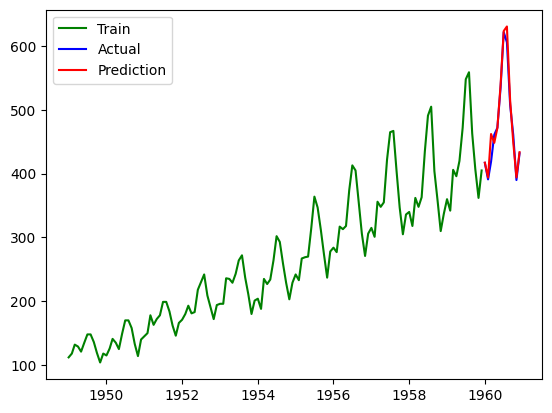

In [47]:
plt.plot(df[:-12].index, train, label= 'Train', color='green')
plt.plot(df[-12:].index, test, label='Actual', color='blue')
plt.plot(df[-12:].index, predictions, label='Prediction', color='red')
plt.legend()
plt.show()